# 1. Importing libraries

In [23]:
# Data processing  
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Pandas options  
# -----------------------------------------------------------------------
pd.options.display.max_colwidth = None

# Path configuration for custom module imports
# -----------------------------------------------------------------------
import sys
sys.path.append('../')

# Ignore warnings  
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

# Clusters and metrics
# -----------------------------------------------------------------------
from yellowbrick.cluster import KElbowVisualizer

# Clustering models
# -----------------------------------------------------------------------
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering

# Custom functions and classes
# -----------------------------------------------------------------------
from src.preprocess import preprocess
from src.eda_support import plot_relation_tv
from src.clustering import *


# 2. Data loading

Aquí hay que limpiar el dataset (duplicados y compound)

In [24]:
df = pd.read_csv('../data/output/circuits.csv', index_col=0)

df.head()

,compound,laptime,max_speed,distance,n_corners,avg_corner_speed,avg_speed,throttle_perc,brake_perc,gear_changes,n_slow_corners,n_medium_corners,n_fast_corners
hockenheimring,SOFT,71.767,320.0,4568.748333,17.0,209.960540,229.888136,78.359322,12.881356,40.0,3,9,5
mugello,SOFT,75.144,309.0,5238.045000,NaN,NaN,251.054662,84.356913,9.967846,24.0,0,0,0
nurburgring,SOFT,85.269,318.0,5112.340000,15.0,173.563856,216.201705,72.281250,17.329545,50.0,5,7,3
portimao,MEDIUM,77.968,314.0,4637.664722,15.0,188.740533,214.136223,73.058824,17.647059,40.0,4,5,6
sochi,SOFT,101.993,291.0,5789.306111,18.0,172.024977,204.520095,69.290780,17.494090,64.0,5,8,5


In [25]:
df = df[df['compound'] == 'SOFT']

In [26]:
# Eliminamos nulos, en este caso solo mugello

df.dropna(inplace=True)

Normalizamos las curvas

In [73]:
df[['n_slow_corners', 'n_medium_corners', 'n_fast_corners']] = df[['n_slow_corners', 'n_medium_corners', 'n_fast_corners']].apply(lambda x: x / df['n_corners'])

# 3. Preprocessing

* Remove the columns we do not want to consider.

    - In this case, we drop `compound`.

* Select the encoding methods for categorical variables.

    - We do not have categorical variables, so we do not need to perform encoding.

* Select the scaling method.

    - We will initially try using a minmax scaler.

In [74]:
encoding_methods = {}

scaling = 'minmax'

df_encoded, df_scaled = preprocess(df, encoding_methods, scaling, columns_drop=['compound'])

# 4. Clustering

## 4.1 K-means

In [75]:
df_scaled.columns

Index(['laptime', 'max_speed', 'distance', 'n_corners', 'avg_corner_speed',
       'avg_speed', 'throttle_perc', 'brake_perc', 'gear_changes',
       'n_slow_corners', 'n_medium_corners', 'n_fast_corners'],
      dtype='object')

In [94]:
df_kmeans = df_scaled

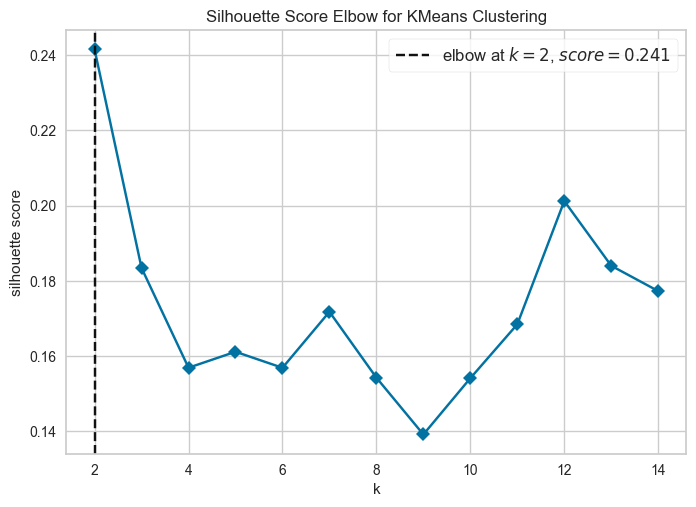

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [98]:
model = KMeans(random_state=42)

visualizer = KElbowVisualizer(model, k=(2, 15), metric="silhouette", timings=False)
visualizer.fit(df_kmeans)
visualizer.show()

In [99]:
model_kmeans = KMeans(n_clusters=12)

km_fit = model_kmeans.fit(df_kmeans)
labels = km_fit.labels_

In [100]:
clustering_metrics(df_kmeans, labels)

,silhouette_score,davies_bouldin_index,cardinality
0,0.177968,0.765267,2
1,0.177968,0.765267,3
2,0.177968,0.765267,4
3,0.177968,0.765267,1
4,0.177968,0.765267,2
5,0.177968,0.765267,4
6,0.177968,0.765267,2
7,0.177968,0.765267,1
8,0.177968,0.765267,1
9,0.177968,0.765267,1


In [101]:
df_kmeans_result = df_kmeans.copy()

df_kmeans_result['cluster'] = km_fit.labels_

In [102]:
df_kmeans_result.sort_values(by='cluster')['cluster']

baku               0
sochi              0
americas           1
vegas              1
yas_marina         1
bahrain            2
istanbul           2
nurburgring        2
ricard             2
rodriguez          3
imola              4
catalunya          4
jeddah             5
suzuka             5
losail             5
silverstone        5
shanghai           6
miami              6
monaco             7
monza              8
marina_bay         9
hockenheimring    10
red_bull_ring     10
albert_park       10
zandvoort         10
hungaroring       11
villeneuve        11
Name: cluster, dtype: int32

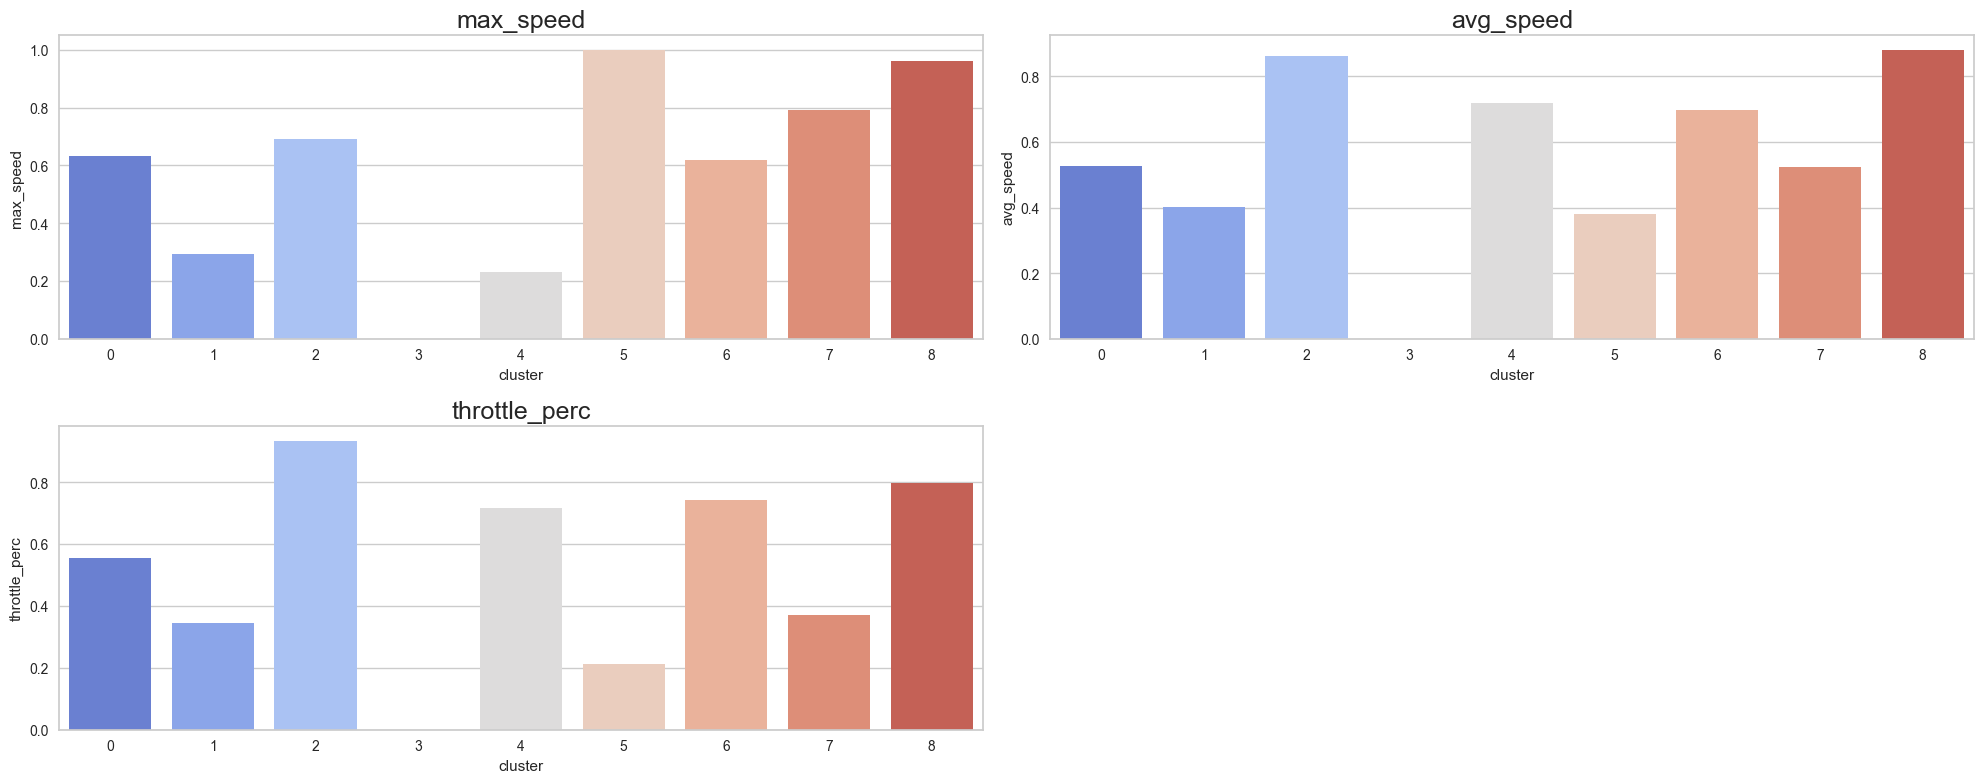

In [16]:
plot_clusters(df_kmeans_result)

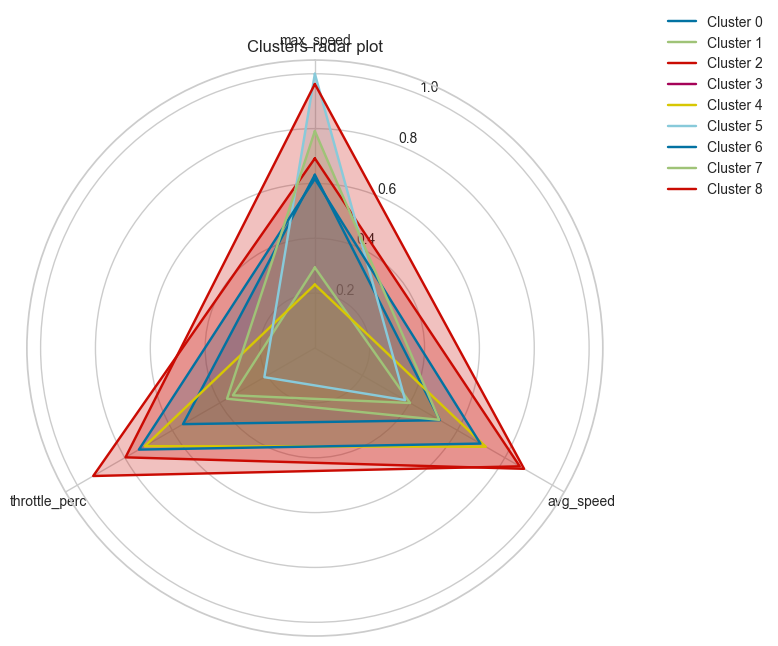

In [17]:
variables = df_kmeans_result.drop(columns='cluster').columns

plot_radar(df_kmeans_result, variables)

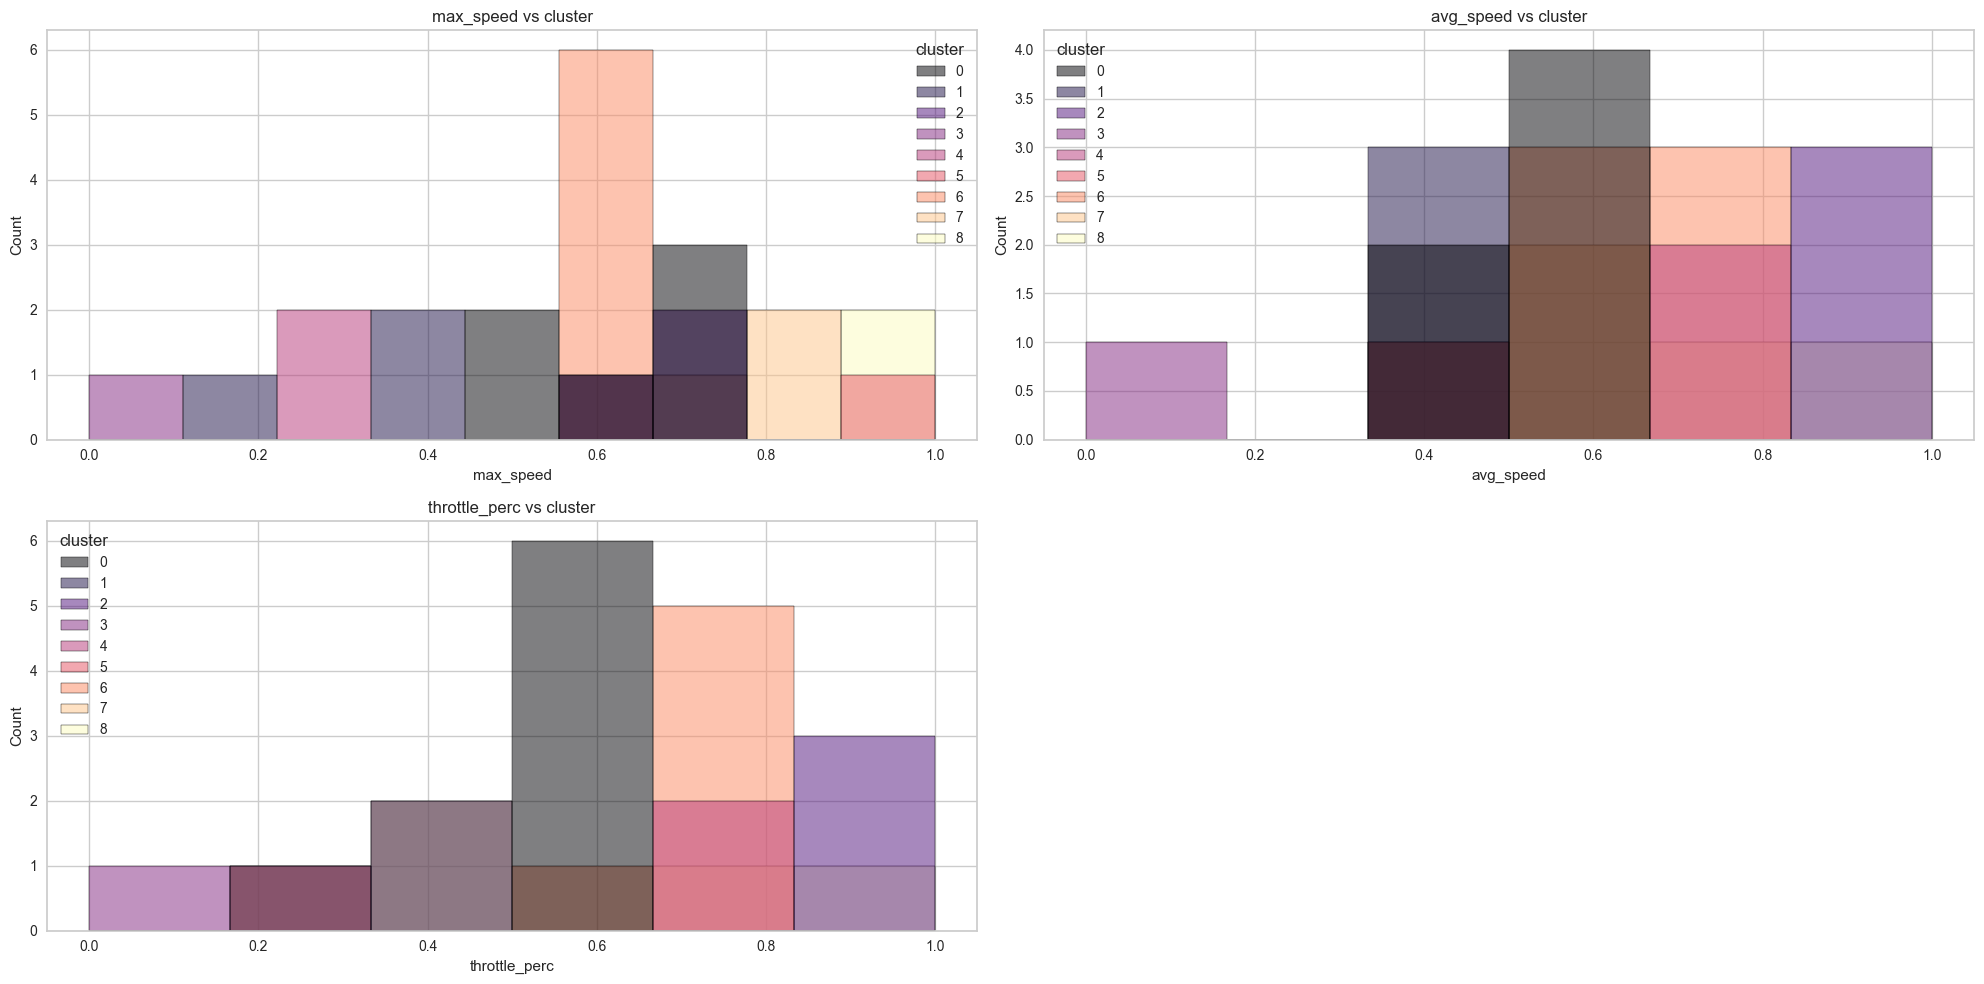

In [19]:
plot_relation_tv(df_kmeans_result, 'cluster', size=(20, 10), n_cols = 2)

## 4.2 Agglomerative clustering

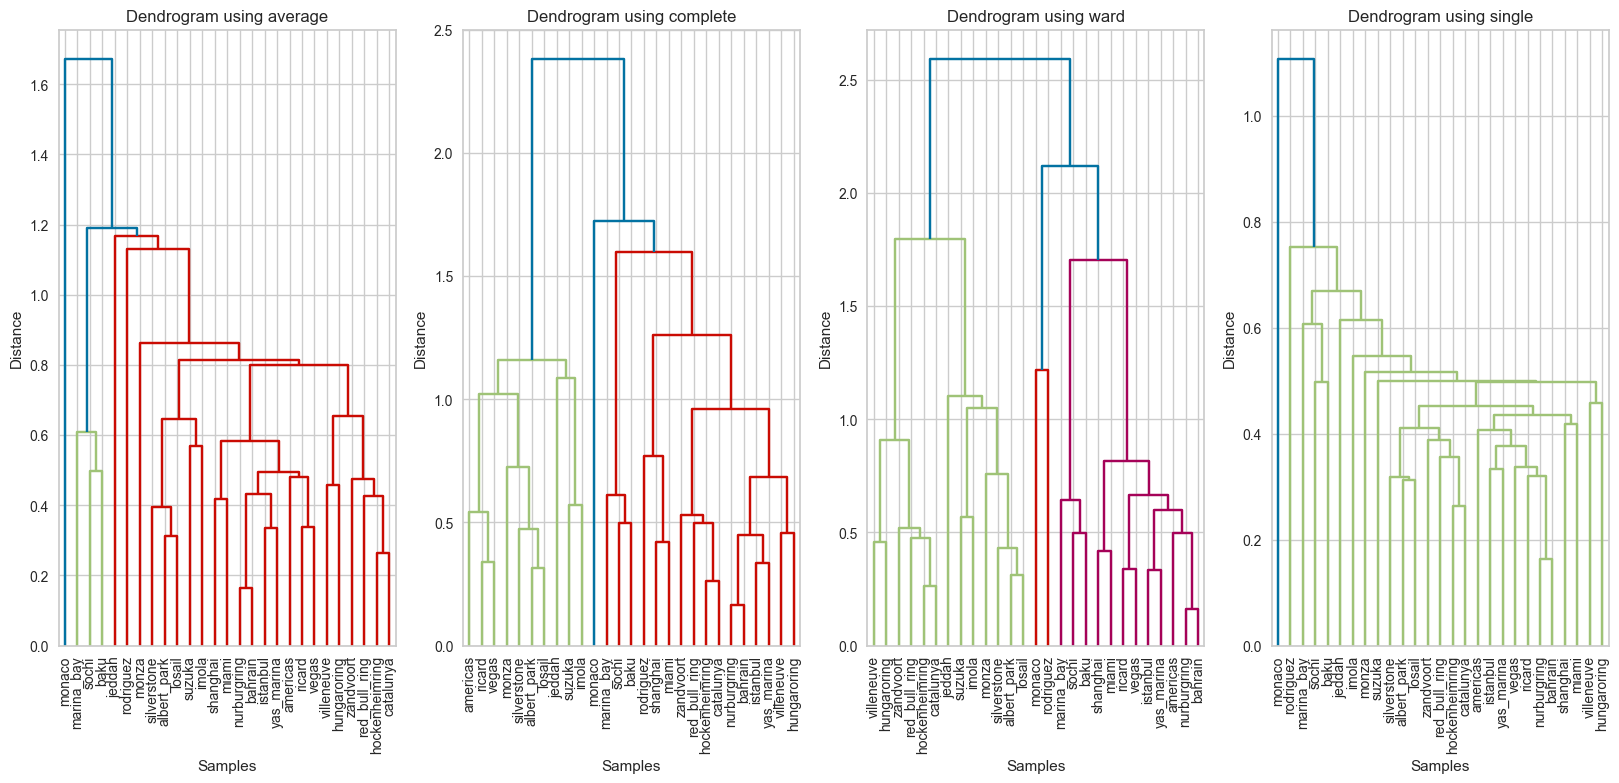

In [20]:
df_copy = df_scaled.copy()

plot_dendrogram(df_copy)